In [1]:
import pandas as pd
import numpy as np
import sys
import anndata
import scanpy as sc
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq

In [2]:
adata = anndata.read_h5ad('../example_datasets/PDAC/PDAC_A/adata.h5ad')
sc.pp.filter_genes(adata, min_cells=20)
adata

AnnData object with n_obs × n_vars = 428 × 5581
    obs: 'x', 'y', 'celltype', 'subtype', 'cluster'
    var: 'n_cells'
    uns: 'cluster_key', 'coord_type', 'is_human', 'moranI', 'spatial_neighbors'
    obsm: 'deconvolution', 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [4]:
R_path = 'source /etc/profile;module load GCC/11.2.0 OpenMPI/4.1.1 R/4.2.0 Anaconda3/2022.05 R-bundle-Bioconductor/3.15-R-4.2.0;R'
out_f = f'../datasets/PDAC/PDAC_A/'

from spider import SPIDER
op = SPIDER()
idata = op.prep(adata, out_f, R_path, cluster_key='cluster', is_human=True, coord_type='grid', no_spatalk=True, imputation=False)
idata, meta_idata = op.find_svi(idata, out_f, R_path, alpha=0.3, abstract=False, overwrite=False, n_jobs=1)
sp = idata.uns['svi']
sp.to_csv(f'{out_f}spider_PDAC.csv')
idata.write_h5ad(f'{out_f}idata.h5ad')



using spatalk result
no spatalk result, using all lrpairs
Using human LR pair dataset.
scoring
using neighbor+sqrt+max
Construct idata with 762 interfaces and 498 LR pairs.
number of interface is less than 1000, skipping abstraction
Added key nnSVG in idata.uns
Added key SOMDE in idata.uns
Added key SpatialDE in idata.uns
Added key SPARKX in idata.uns
Added key scGCO in idata.uns
Added key moranI in idata.uns
Added key gearyC in idata.uns
Using the results from SVI identification methods: ['SOMDE' 'SpatialDE' 'SPARKX' 'nnSVG' 'scGCO' 'gearyC' 'moranI']
225/498 SVIs identified (threshold=0.01).


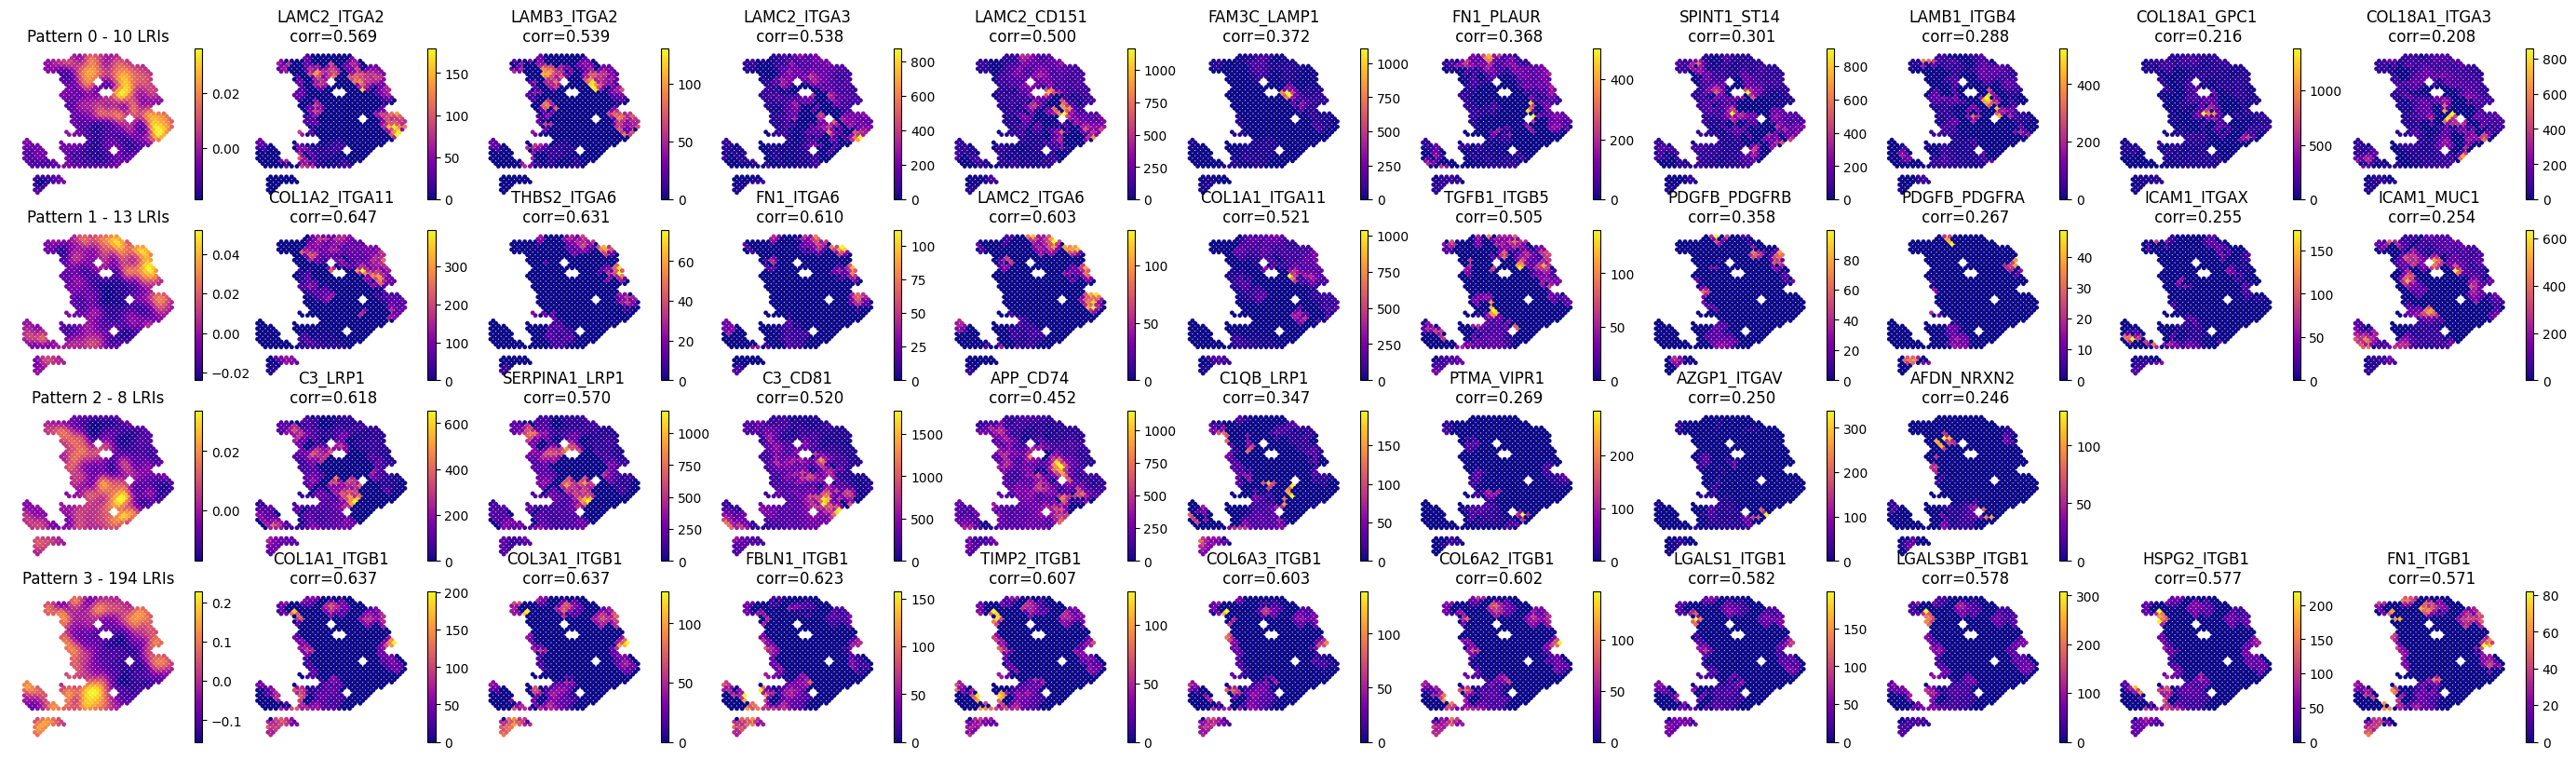

In [5]:
plt.rcParams.update({'font.size': 10})
op.vis.pattern_LRI(idata,show_SVI=10, spot_size=12)

In [9]:
def ct_chord(idata, svi):
    import holoviews as hv
    from holoviews import opts, dim
    df = pd.concat([idata.to_df()[svi],  idata.obs], axis=1)
    df['direction'] = np.array(idata[:, idata.var_names==svi].layers['direction']).flatten()
    df['arrow'] = df.apply(lambda x: f'{x.A_label}->{x.B_label}' if x.direction==0 else f'{x.B_label}->{x.A_label}', axis=1)
    input_df = df.groupby('arrow')[svi].mean().reset_index(drop=False).query(f'{svi} > 0')
    input_df[['source', 'target']] = input_df['arrow'].str.split('->', expand=True).to_numpy() 
    node_df = pd.DataFrame(index=np.unique(np.concatenate((input_df['source'].to_numpy(), input_df['target'].to_numpy()))))
    node_df['group'] = 1
    links_df = input_df[['source', 'target', svi]]
    links_df.columns = ['source', 'target', 'value']

    hv.extension('bokeh')
    hv.output(size=200)

    nodes = hv.Dataset(node_df, 'index')
    def rotate_label(plot, element):
        angles = plot.handles['text_1_source'].data['angle']
        characters = np.array(plot.handles['text_1_source'].data['text'])
        plot.handles['text_1_source'].data['text'] = np.array([x + ' ' * int(len(x)) if x in characters[np.where((angles < -1.5707963267949) | (angles > 1.5707963267949))] else x for x in plot.handles['text_1_source'].data['text']])
        new_text = []
        for x in plot.handles['text_1_source'].data['text']:
            new = x
            if x in characters[np.where((angles > -1.5707963267949) & (angles < 1.5707963267949))]:
                new = ' ' * int(len(x)) + new
            if x in characters[np.where((angles > -1.5707963267949) & (angles < 0))]:
                # new = '\n' + new
                new = '\n\n' + new
            else:
                # new = new + '\n'
                new = new + '\n\n'
            new_text.append(new)
        plot.handles['text_1_source'].data['text'] = np.array(new_text)
        
        # plot.handles['text_1_source'].data['text'] = np.array([x + ' ' * (len(x)*2 + 5) if x in characters[np.where((angles < -1.5707963267949) | (angles > 1.5707963267949))] else x for x in plot.handles['text_1_source'].data['text']])
        # plot.handles['text_1_source'].data['text'] = np.array([x+'\n' for x in plot.handles['text_1_source'].data['text']])
        # angles += 3.1415926535898 * 1.5
        # angles[np.where((angles < -1.5707963267949) | (angles > 1.5707963267949))] += 3.1415926535898 * 1.5
        # angles[np.where((angles > 1.5707963267949))] += 3.1415926535898 * 1.5 # left top
        # angles[np.where((angles < -1.5707963267949))] += 3.1415926535898 * 1.5 # left bottom
        # angles[np.where((angles < 1.5707963267949)  & (angles > 0) )] += 3.1415926535898 * 1.5 # right top
        # angles[np.where((angles > -1.5707963267949) & (angles < 0))] += 3.1415926535898 * 0.5 # right bottom
        angles[np.where((angles > 1.5707963267949))] = 0 # left top
        angles[np.where((angles < -1.5707963267949))] = 0  # left bottom
        angles[np.where((angles < 1.5707963267949)  & (angles > 0) )] = 0 # right top
        angles[np.where((angles > -1.5707963267949) & (angles < 0))] = 0 # right bottom
        # angles = np.zeros(len(angles))
        plot.handles['text_1_glyph'].text_align = "center"
    chord = hv.Chord((links_df, nodes))
    chord.opts(
        opts.Chord(cmap='Set2', edge_cmap='Set2', edge_color=dim('source').str(), 
                labels='index', node_color=dim('index').str(),   hooks=[rotate_label], label_text_font_size='17pt', title=f'{svi}'),
    )
    return chord

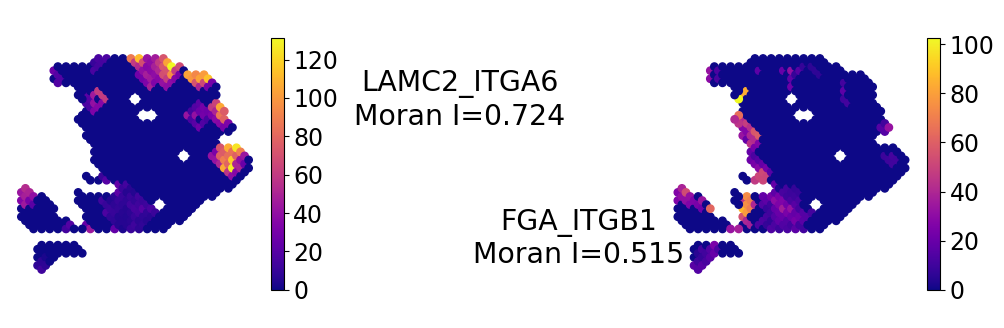

In [6]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update({'font.size': 17})
plt.figure(figsize=(12, 4))
base = 1
for i in ['LAMC2_ITGA6', 'FGA_ITGB1']:
    if i == 'LAMC2_ITGA6':
        plt.subplot(1, 3, 1)
    else:
        plt.subplot(1, 3, 3)

    im=plt.scatter(idata.obsm['spatial'][:, 0], idata.obsm['spatial'][:, 1], c=idata.to_df()[i].to_numpy(), s=28, cmap='plasma')
    # sns.scatterplot(marker_score, x='x', y='y', hue=i, s=10, linewidth=0)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.axis('equal')
    plt.axis('off')
    if i == 'LAMC2_ITGA6':
        plt.title(f'{i}\nMoran I={"%.3f" % idata.uns["moranI"].loc[i]["I"]}', rotation='horizontal',x=1.8,y=0.6)
    else:
        plt.title(f'{i}\nMoran I={"%.3f" % idata.uns["moranI"].loc[i]["I"]}', rotation='horizontal',x=-0.35,y=0.15)

    base += 1
rcParams.update(rcParamsDefault)
plt.show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
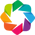

:Chord   [source,target]   (value)

In [10]:
ct_chord(idata, 'LAMC2_ITGA6')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
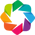

:Chord   [source,target]   (value)

In [11]:
ct_chord(idata, 'FGA_ITGB1')

In [5]:
op.util.save_runningtime(idata, save=f'{out_f}runningtime.json')

{'nnSVG_time': 321.64437794685364,
 'SOMDE_time': 8.303577899932861,
 'SpatialDE_time': 23.874626636505127,
 'SPARKX_time': 3.324079990386963,
 'scGCO_time': 79.35316395759583,
 'moranI_time': 44.44893288612366,
 'gearyC_time': 44.09772348403931,
 'interface': 762,
 'LRI': 498}

In [15]:
import numpy
numpy.float = numpy.float64
import spatialdm as sdm
adata_sdm = anndata.read_h5ad('../example_datasets/PDAC/PDAC_A/adata.h5ad')
sc.pp.filter_genes(adata_sdm, min_cells=20)
adata_sdm.raw = adata_sdm
np.random.seed(0)
import time
start = time.time()
sdm.weight_matrix(adata_sdm, l=1.2, cutoff=0.2, single_cell=False) # weight_matrix by rbf kernel
sdm.extract_lr(adata_sdm, 'human', min_cell=3)      # find overlapping LRs from CellChatDB
sdm.spatialdm_global(adata_sdm, 1000, specified_ind=None, method='permutation', nproc=1)     # global Moran selection # SPIDER changed from both to permutation because both will throw shape diff error
sdm.sig_pairs(adata_sdm, method='permutation', fdr=True, threshold=0.01)     # select significant pairs
end = time.time()
runtime=end-start
print(divmod(runtime, 60))
start = time.time()
sdm.spatialdm_local(adata_sdm, n_perm=1000, method='both', specified_ind=None, nproc=1)     # local spot selection
sdm.sig_spots(adata_sdm, method='permutation', fdr=True, threshold=0.01)     # significant local spots # SPIDER changed fdr to true
end = time.time()
runtime=end-start
# format runtime to seconds
print(divmod(runtime, 60))
# import spatialdm.plottings as pl
# pl.global_plot(new_adata_99)
dm = adata_sdm.uns['global_res']
dm.to_csv(f'{out_f}spatialdm_PDAC.csv')

100%|██████████| 1000/1000 [00:09<00:00, 103.93it/s]


(0.0, 19.993462562561035)


100%|██████████| 1000/1000 [00:14<00:00, 68.96it/s]


(0.0, 19.93867802619934)


In [17]:
dm = pd.read_csv(f'{out_f}spatialdm_PDAC.csv', index_col=0)
dm = dm.query('selected==True')
dm_expand = []
addition = []
for x in dm.to_numpy():
    l, r1, r2, _, fdr, _ = x
    if r2:
        addition.append([l, r1, fdr])
        addition.append([l, r2, fdr])
    else:
        dm_expand.append([l, r1, fdr])
dm_expand = pd.DataFrame(dm_expand, columns=['ligand', 'receptor', 'fdr'])
dm_expand.index = dm_expand['ligand'] + '_' + dm_expand['receptor']

addition = pd.DataFrame(addition, columns=['ligand', 'receptor', 'fdr'])
addition['lr'] = addition['ligand'] + '_' + addition['receptor']
addition = addition.loc[addition.groupby('lr')['fdr'].idxmin()][['ligand', 'receptor', 'fdr']]
addition.index = addition['ligand'] + '_' + addition['receptor'] 
                                                         
dm_expand = pd.concat([dm_expand[['fdr']], addition[~addition.index.isin(dm_expand.index)][['fdr']]])
dm_expand = dm_expand.loc[dm_expand.index.isin(idata.var_names)]
dm_expand = dm_expand.reset_index().drop_duplicates().set_index('index')

In [18]:
svi_df, svi_df_strict = op.svi.combine_SVI(idata,threshold=0.01)

Using the results from SVI identification methods: ['SOMDE' 'SpatialDE' 'SPARKX' 'nnSVG' 'scGCO' 'gearyC' 'moranI']
225/498 SVIs identified (threshold=0.01).


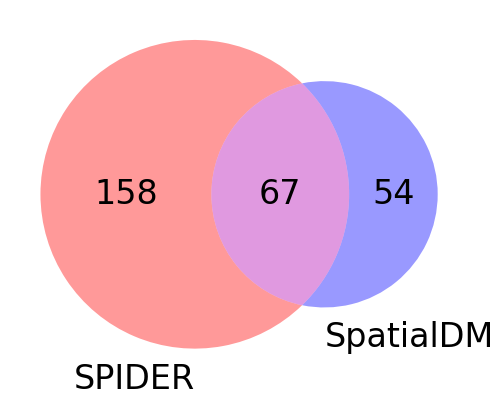

In [19]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2,venn2_circles
out=venn2(subsets=[set(svi_df_strict.index), set(dm_expand.index)], set_labels = ('SPIDER', 'SpatialDM'), set_colors=('red', 'blue'))
for text in out.set_labels:
    text.set_fontsize(24)
for text in out.subset_labels:
    text.set_fontsize(24)
plt.show()

In [20]:
sdm_unique = dm_expand.loc[(list(set(dm_expand.index) - set(svi_df_strict.index)))].sort_values('fdr').index
sp_unique = svi_df_strict.loc[(list(set(svi_df_strict.index) - set(dm_expand.index)))].max(axis=1).sort_values().index
shared = list(set(dm_expand.index) & set(svi_df_strict.index))

evaluating with ['moranI' 'gearyC' 'SOMDE' 'nnSVG']
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

LR
(SOMDE)_SpatialDM vs. LR
(SOMDE)_Excluded: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:6.196e-02 U_stat=6.713e+03
LR
(nnSVG)_SpatialDM vs. LR
(nnSVG)_Excluded: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:1.043e-01 U_stat=6.567e+03
Geary
C (rev.)_SpatialDM vs. Geary
C (rev.)_Excluded: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:2.881e-01 U_stat=6.204e+03
Moran
I_SpatialDM vs. Moran
I_Excluded: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:2.947e-01 U_stat=6.194e+03
Moran
I_SPIDER vs. Moran
I_SpatialDM: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:5.931e-07 U_stat=6.157e+03
Geary
C (rev.)_SPIDER v

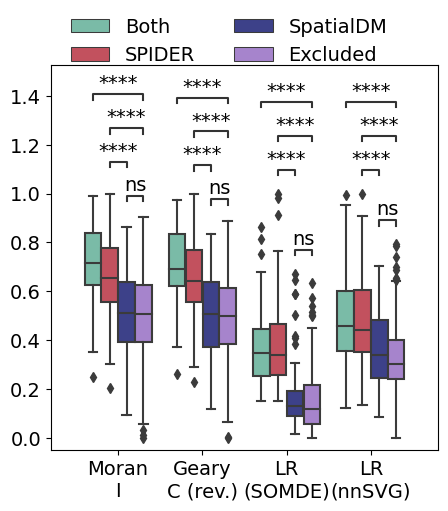

In [21]:
import seaborn as sns
from statannotations.Annotator import Annotator
methods = np.array(['moranI', 'gearyC', 'SOMDE', 'nnSVG'])[np.isin(['SOMDE', 'nnSVG', 'gearyC', 'moranI'],list(idata.uns.keys()))]
print(f'evaluating with {methods}')
dfs = []
metrics = []
for i in methods:
    if i == 'gearyC':
        dfs.append(-idata.uns['gearyC'][['C']])
        metrics.append("Geary\nC (rev.)")
    elif i == 'moranI':
        dfs.append(idata.uns['moranI'][['I']]),
        metrics.append("Moran\nI")
    elif i == 'SOMDE':
        # dfs.append(idata.uns['SOMDE'].set_index('g')['FSV']),
        # metrics.append("FSV\n(SOMDE)") 
        dfs.append(idata.uns['SOMDE'].set_index('g')['LLR']),
        metrics.append("LR\n(SOMDE)") 
    elif i == 'nnSVG':
        dfs.append(idata.uns['nnSVG']['LR_stat']),
        metrics.append("LR\n(nnSVG)") 

pairs = []
for i in metrics:
    pairs.append( ((i, 'Both'), (i, 'Excluded')) )
    pairs.append( ((i, 'SPIDER'), (i, 'Excluded')) )
    pairs.append( ((i, 'SpatialDM'), (i, 'Excluded')) )
    pairs.append( ((i, 'SPIDER'), (i, 'SpatialDM')) )
df = pd.concat(dfs, axis=1)
df.columns=metrics

normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df = normalized_df.fillna(0)
normalized_df['Category'] = 'Excluded'
normalized_df.loc[sdm_unique, 'Category'] = 'SpatialDM'
normalized_df.loc[sp_unique, 'Category'] = 'SPIDER'
normalized_df.loc[shared, 'Category'] = 'Both'

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(5, 5))

normalized_df = normalized_df.melt(id_vars='Category', value_vars=metrics, var_name='Metric')
ax =sns.boxplot(data=normalized_df,x='Metric',y='value', hue='Category', 
                palette={'SpatialDM':'#313695', 'SPIDER': '#D53E4F', 'Both': '#6FC6AB', 'Excluded': '#A578D8'}, 
                width=0.8, hue_order=['Both', 'SPIDER', 'SpatialDM', 'Excluded'])
ax.legend(loc='upper center',ncol=2, bbox_to_anchor=(0.46, 1.17), frameon=False)
annot = Annotator(ax, pairs, data=normalized_df, x='Metric',y='value', hue='Category', hue_order=['Both', 'SPIDER', 'SpatialDM', 'Excluded'])
annot.configure(test='Mann-Whitney-gt',comparisons_correction="BH", correction_format="replace")
annot.apply_and_annotate()
ax.set_ylabel('')    
ax.set_xlabel('')
plt.show()

In [22]:
picked_dm = idata.uns['moranI'].loc[sdm_unique].sort_values('I', ascending=False).head(10).index

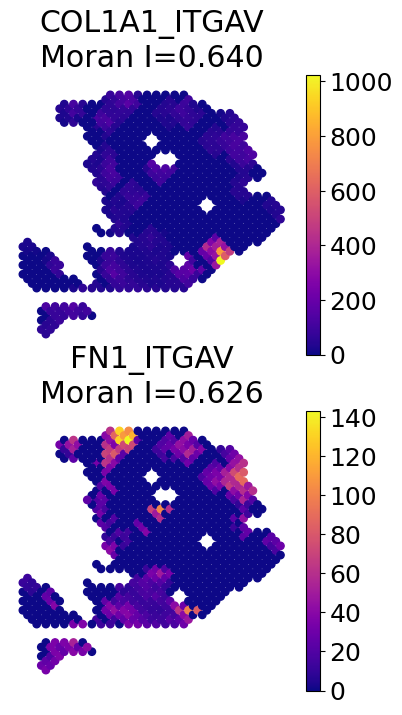

In [23]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update({'font.size': 18})
plt.figure(figsize=(4, 8))
base = 1
for i in picked_dm[:2]:
    plt.subplot(2, 1, base)
    im=plt.scatter(idata.obsm['spatial'][:, 0], idata.obsm['spatial'][:, 1], c=idata.to_df()[i].to_numpy(), s=28, cmap='plasma')
    # sns.scatterplot(marker_score, x='x', y='y', hue=i, s=10, linewidth=0)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.axis('equal')
    plt.axis('off')
    plt.title(f'{i}\nMoran I={"%.3f" % idata.uns["moranI"].loc[i]["I"]}')
    base += 1
rcParams.update(rcParamsDefault)
plt.show()

In [24]:
picked_sp = idata.uns['moranI'].loc[sp_unique].sort_values('I', ascending=False).head(10).index

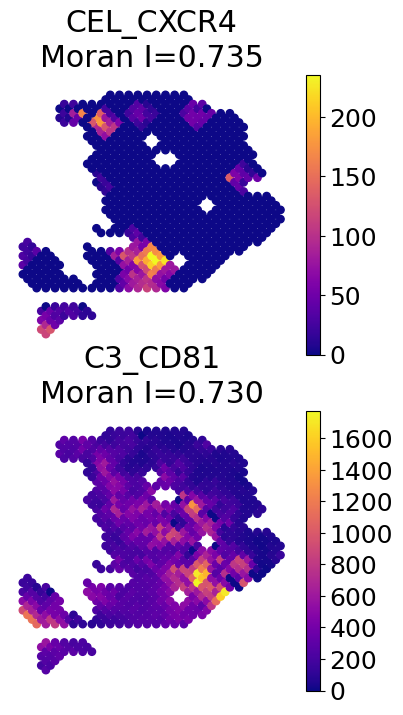

In [25]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update({'font.size': 18})
plt.figure(figsize=(4, 8))
base = 1
for i in picked_sp[:2]:
    plt.subplot(2, 1, base)
    im=plt.scatter(idata.obsm['spatial'][:, 0], idata.obsm['spatial'][:, 1], c=idata.to_df()[i].to_numpy(), s=28, cmap='plasma')
    # sns.scatterplot(marker_score, x='x', y='y', hue=i, s=10, linewidth=0)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.axis('equal')
    plt.axis('off')
    plt.title(f'{i}\nMoran I={"%.3f" % idata.uns["moranI"].loc[i]["I"]}')
    base += 1
rcParams.update(rcParamsDefault)
plt.show()

In [26]:
picked_shared = idata.uns['moranI'].loc[shared].sort_values('I', ascending=False).head(10).index

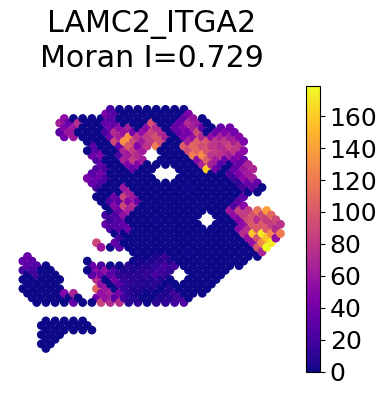

In [27]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update({'font.size': 18})
plt.figure(figsize=(4, 4))
base = 1
for i in picked_shared[:1]:
    plt.subplot(1, 1, base)
    im=plt.scatter(idata.obsm['spatial'][:, 0], idata.obsm['spatial'][:, 1], c=idata.to_df()[i].to_numpy(), s=28, cmap='plasma')
    # sns.scatterplot(marker_score, x='x', y='y', hue=i, s=10, linewidth=0)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.axis('equal')
    plt.axis('off')
    plt.title(f'{i}\nMoran I={"%.3f" % idata.uns["moranI"].loc[i]["I"]}')
    base += 1
rcParams.update(rcParamsDefault)
plt.show()

Added key cell_pattern in idata.uns
Added key cell_score in idata.uns
Added key interaction_pattern, interaction_score in adata.obsm
Added key rank_interaction_score_groups, rank_interaction_pattern_groups in adata.uns


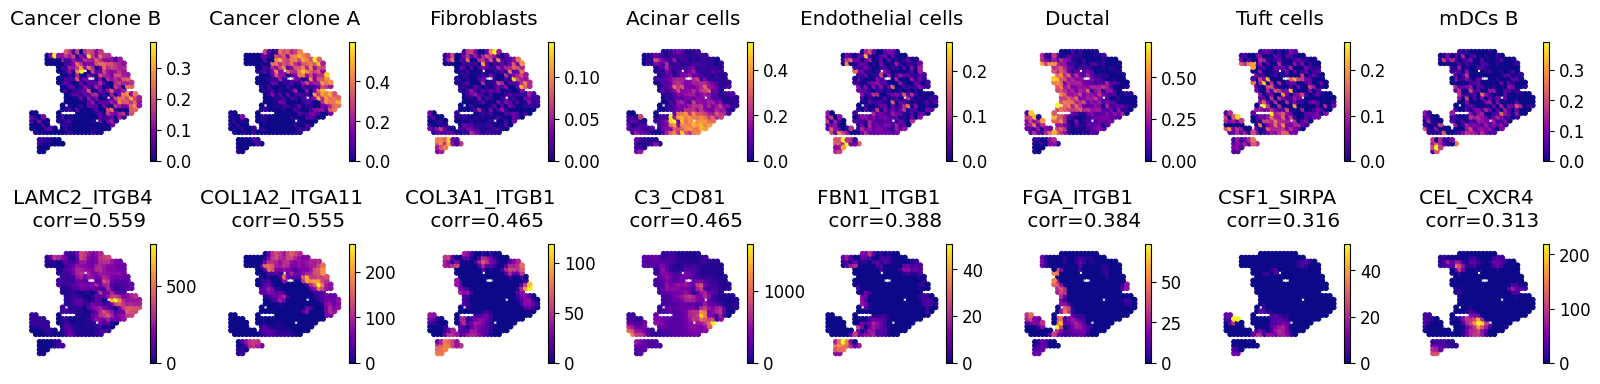

In [31]:

adata, adata_lri, adata_pattern = op.cell_transform(idata[:, idata.var['is_svi']==1], adata, label=adata.uns['cluster_key'])


st_decon = adata.obsm['deconvolution']
st_decon_org = st_decon.copy()
decon_corr = pd.concat([st_decon, adata_lri.to_df()], axis=1).corr()[adata_lri.var_names].loc[st_decon.columns].T
decon_corr_sup = decon_corr.loc[decon_corr.idxmax()] 
decon_corr = decon_corr[decon_corr_sup.columns[np.argsort(-decon_corr_sup.to_numpy().diagonal())]]
decon_corr_sup = decon_corr.loc[decon_corr.idxmax()] 
plt.rcParams.update({'font.size': 12})
st_decon = st_decon_org.copy()
corrs = decon_corr_sup.to_numpy().diagonal()
celtypes = decon_corr_sup.columns[corrs>0.3]
st_decon = pd.concat([idata.uns['cell_meta'][['x', 'y']], st_decon], axis=1)
plt.figure(figsize=(len(celtypes)*2, 4))
base = 1
for i in celtypes:
    plt.subplot(2, len(celtypes), base)
    # sns.scatterplot(st_decon, x='x', y='y', hue=i, s=10, linewidth=0)
    im=plt.scatter(st_decon['x'],st_decon['y'], c=st_decon[i], s=10, cmap='plasma')
    plt.colorbar(im,fraction=0.046, pad=0.04)

    plt.axis('equal')
    plt.axis('off')
    plt.title(i.replace('_', ' '))
    base += 1
    

marker_score = adata_lri.to_df()[np.unique(decon_corr_sup.index)]
marker_score = pd.concat([adata_lri.obs[['x', 'y']], marker_score], axis=1)
for i in range(len(decon_corr_sup.index[corrs>0.3])):
    plt.subplot(2, len(celtypes), base)
    im=plt.scatter(marker_score['x'],marker_score['y'], c=marker_score[decon_corr_sup.index[i]].to_numpy(), s=10, cmap='plasma')
    # sns.scatterplot(marker_score, x='x', y='y', hue=i, s=10, linewidth=0)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.axis('equal')
    plt.axis('off')
    plt.title(f'{decon_corr_sup.index[i]} \n corr={"%.3f" % corrs[i]}')
    base += 1

plt.tight_layout()
plt.show()

In [32]:
adata, adata_lri, adata_pattern = op.cell_transform(idata[:, idata.var_names.isin(sp_unique)], adata, label=adata.uns['cluster_key'])


st_decon = adata.obsm['deconvolution']
st_decon_org = st_decon.copy()
decon_corr = pd.concat([st_decon, adata_lri.to_df()], axis=1).corr()[adata_lri.var_names].loc[st_decon.columns].T
decon_corr_sup = decon_corr.loc[decon_corr.idxmax()] 
decon_corr = decon_corr[decon_corr_sup.columns[np.argsort(-decon_corr_sup.to_numpy().diagonal())]]
decon_corr_sup = decon_corr.loc[decon_corr.idxmax()] 

# function for each column in df, keep the top 10 values, and set others to 0
def top10(df):
    df = df.copy()
    for i in df.columns:
        df[i] = df[i].where(df[i].rank(method='min', ascending=False) <= 10, np.nan)
        # df[i] = df[i].where(df[i] > 0.1, np.nan)
    return df
decon_corr_sub = top10(decon_corr)
decon_corr_sub = decon_corr_sub.melt(var_name='cell_type', value_name='gene').dropna()
decon_corr_sub['method'] = 'SPIDER'

# idata_copy = idata_copy[:, idata.var['is_svi']==1]
adata, adata_lri, adata_pattern = op.cell_transform(idata[:, idata.var_names.isin(sdm_unique)], adata, label=adata.uns['cluster_key'])


st_decon = adata.obsm['deconvolution']
st_decon_org = st_decon.copy()
decon_corr = pd.concat([st_decon, adata_lri.to_df()], axis=1).corr()[adata_lri.var_names].loc[st_decon.columns].T
decon_corr_sup = decon_corr.loc[decon_corr.idxmax()] 
decon_corr = decon_corr[decon_corr_sup.columns[np.argsort(-decon_corr_sup.to_numpy().diagonal())]]
decon_corr_sup = decon_corr.loc[decon_corr.idxmax()] 
plt.rcParams.update({'font.size': 18})
st_decon = st_decon_org.copy()
celtypes = decon_corr_sup.columns
st_decon = pd.concat([idata.uns['cell_meta'][['x', 'y']], st_decon], axis=1)

decon_corr_sub_sdm = top10(decon_corr)
decon_corr_sub_sdm = decon_corr_sub_sdm.melt(var_name='cell_type', value_name='gene').dropna()
decon_corr_sub_sdm['method'] = 'SpatialDM'
decon_corr_sub = pd.concat([decon_corr_sub, decon_corr_sub_sdm], axis=0)
useful_celltype =  decon_corr_sub.groupby(['cell_type'])['gene'].max()
useful_celltype  = useful_celltype[useful_celltype > 0.3].index
decon_corr_sub = decon_corr_sub[decon_corr_sub['cell_type'].isin(useful_celltype)]
decon_corr_sub.cell_type = decon_corr_sub.cell_type.str.replace('_', ' ')
# decon_corr_sub.cell_type = decon_corr_sub.cell_type.str.replace(' ', '\n', 1)

Added key cell_pattern in idata.uns
Added key cell_score in idata.uns
Added key interaction_pattern, interaction_score in adata.obsm
Added key rank_interaction_score_groups, rank_interaction_pattern_groups in adata.uns
Added key cell_pattern in idata.uns
Added key cell_score in idata.uns
Added key interaction_pattern, interaction_score in adata.obsm
Added key rank_interaction_score_groups, rank_interaction_pattern_groups in adata.uns


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tuft cells_SPIDER vs. Tuft cells_SpatialDM: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:9.134e-05 U_stat=1.000e+02
mDCs B_SPIDER vs. mDCs B_SpatialDM: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:1.101e-03 U_stat=9.100e+01
Endothelial cells_SPIDER vs. Endothelial cells_SpatialDM: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:5.040e-04 U_stat=9.400e+01
Cancer clone A_SPIDER vs. Cancer clone A_SpatialDM: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:9.134e-05 U_stat=1.000e+02
Fibroblasts_SPIDER vs. Fibroblasts_SpatialDM: Mann-Whitney-Wilcoxon test greater with Benjamini-Hochberg correction, P_val:2.898e-03 U_stat=8.700e+01
Acinar cells_SPIDER vs. Acinar cells_SpatialDM: Mann-Whitney-Wi

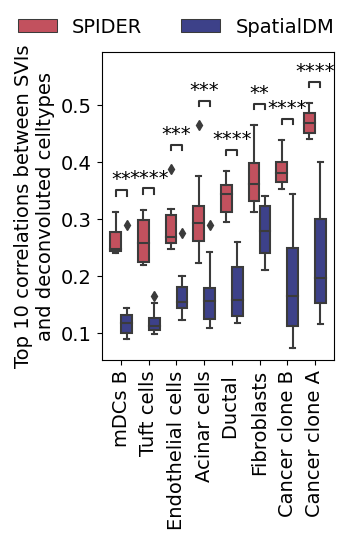

In [33]:
# sort x axis order by diffence between two hue
plt.figure(figsize=(3, 4))
plt.rcParams.update({'font.size': 14})

decon_corr_sub['cell_type'] = decon_corr_sub['cell_type'].astype('category')
pairs = []
for i in list(decon_corr_sub['cell_type'].unique()):
    pairs.append( ((i, 'SPIDER'), (i, 'SpatialDM')) )
ax =sns.boxplot(data=decon_corr_sub, x='cell_type', y='gene', hue='method',
                order = (decon_corr_sub.query('method=="SPIDER"').groupby(['cell_type'])['gene'].median()).sort_values().index,
                # order = (decon_corr_sub.query('method=="SPIDER"').groupby(['cell_type'])['gene'].median() - decon_corr_sub.query('method=="SpatialDM"').groupby(['cell_type'])['gene'].median()).sort_values().index,
                palette={'SpatialDM':'#313695', 'SPIDER': '#D53E4F'})
annot = Annotator(ax, pairs, data=decon_corr_sub, x='cell_type',y='gene', hue='method', order=decon_corr_sub.query('method=="SPIDER"').groupby(['cell_type'])['gene'].median().sort_values().index)
annot.configure(test='Mann-Whitney-gt',comparisons_correction="BH", correction_format="replace")
annot.apply_and_annotate()
# rotate x axis
plt.xticks(rotation=90)
# move legend up center
ax.legend(loc='upper center',ncol=2, bbox_to_anchor=(0.32, 1.17), frameon=False)
plt.ylabel('Top 10 correlations between SVIs\nand deconvoluted celltypes')
plt.xlabel('')
plt.show()

In [34]:
adata, adata_lri, adata_pattern = op.cell_transform(idata, adata, label=adata.uns['cluster_key'])


Added key cell_pattern in idata.uns
Added key cell_score in idata.uns
Added key interaction_pattern, interaction_score in adata.obsm
Added key rank_interaction_score_groups, rank_interaction_pattern_groups in adata.uns


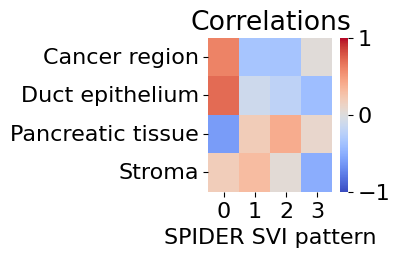

In [35]:
# column wise correlation bettwen two numpy arrays X and Y
ldf = pd.get_dummies(adata.obs['cluster'])
plt.figure(figsize=(2, 2))
plt.rcParams.update({'font.size': 16})
sns.heatmap(np.corrcoef(adata.obsm['interaction_pattern'], ldf.to_numpy(),  rowvar=False)[4:, :4].T, vmin=-1, vmax=1, cmap='coolwarm', yticklabels=ldf.columns.str.replace('_', ' '),)
plt.xlabel('SPIDER SVI pattern')
# change title position
plt.title('Correlations')
plt.tight_layout()
plt.show()


In [36]:
np.corrcoef(adata.obsm['interaction_pattern'], ldf.to_numpy(),  rowvar=False)[4:, :4].T

array([[ 0.60904411, -0.34989026, -0.35480133,  0.02689207],
       [ 0.70319265, -0.1103473 , -0.21477382, -0.40098495],
       [-0.61287592,  0.19312081,  0.40457619,  0.08963588],
       [ 0.18689784,  0.3123452 ,  0.04243012, -0.5118526 ]])

In [37]:
np.corrcoef(adata.obsm['interaction_pattern'].T)

array([[ 1.        ,  0.3402558 , -0.68452566, -0.21508738],
       [ 0.3402558 ,  1.        , -0.57763038,  0.43957241],
       [-0.68452566, -0.57763038,  1.        , -0.10639997],
       [-0.21508738,  0.43957241, -0.10639997,  1.        ]])

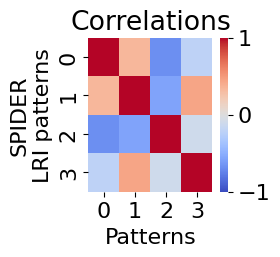

In [38]:
# column wise correlation bettwen two numpy arrays X and Y
plt.figure(figsize=(2, 2))
plt.rcParams.update({'font.size': 16})
sns.heatmap(np.corrcoef(adata.obsm['interaction_pattern'].T), vmin=-1, vmax=1, cmap='coolwarm')
plt.xlabel('Patterns')
plt.title('Correlations')
plt.ylabel('SPIDER\nLRI patterns')


# plt.tight_layout(bbox_inches='tight')
# change title position
# plt.title('Correlations')
plt.show()

In [39]:
import NaiveDE
import SpatialDE
bin_spots = adata_sdm.uns['selected_spots'].astype(int)[adata_sdm.uns['local_stat']['n_spots']>2]

print(bin_spots.shape[0], " pairs used for spatial clustering")
from threadpoolctl import threadpool_limits

with threadpool_limits(limits=1, user_api='blas'):
    results = SpatialDE.run(adata_sdm.obsm['spatial'], bin_spots.transpose())
    np.random.seed(0)
    
    histology_results, patterns = SpatialDE.aeh.spatial_patterns(
        adata_sdm.obsm['spatial'], bin_spots.transpose(), results, C=4, l=3, verbosity=1)



129  pairs used for spatial clustering


Models: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


iter 0, ELBO: -6.35e+10
iter 1, ELBO: -3.18e+10, delta_ELBO: 3.16e+10
iter 2, ELBO: -3.18e+10, delta_ELBO: 1.11e+04
iter 3, ELBO: -3.18e+10, delta_ELBO: 2.87e+03
iter 4, ELBO: -3.18e+10, delta_ELBO: 7.40e+02
iter 5, ELBO: -3.18e+10, delta_ELBO: 4.65e+01
iter 6, ELBO: -3.18e+10, delta_ELBO: 4.41e+00
iter 7, ELBO: -3.18e+10, delta_ELBO: 1.65e+00
iter 8, ELBO: -3.18e+10, delta_ELBO: 1.21e+00
iter 9, ELBO: -3.18e+10, delta_ELBO: 7.01e-02
iter 10, ELBO: -3.18e+10, delta_ELBO: 2.12e+00
iter 11, ELBO: -3.18e+10, delta_ELBO: 1.48e+00
iter 12, ELBO: -3.18e+10, delta_ELBO: 1.50e-01
iter 13, ELBO: -3.18e+10, delta_ELBO: 1.59e-02
iter 14, ELBO: -3.18e+10, delta_ELBO: 4.73e-03
Converged on iter 14


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
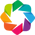

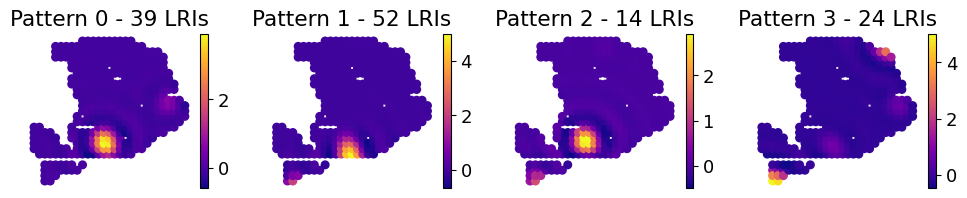

In [40]:
plt.figure(figsize=(12,2))
import spatialdm.plottings as pl
plt.rcParams.update({'font.size': 13})

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.scatter(adata_sdm.obsm['spatial'][:,0], adata_sdm.obsm['spatial'][:,1], c=patterns[i], s=30, cmap='plasma',);
    plt.axis('equal')
    plt.axis('off')
    pl.plt_util('Pattern {} - {} LRIs'.format(i, histology_results.query('pattern == @i').shape[0] ))
plt.show()
    

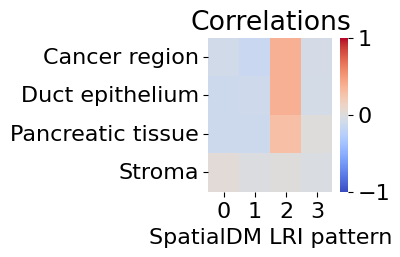

In [41]:
# column wise correlation bettwen two numpy arrays X and Y
ldf = pd.get_dummies(adata_sdm.obs['cluster'])
plt.figure(figsize=(2, 2))
plt.rcParams.update({'font.size': 16})
sns.heatmap(np.corrcoef(patterns, ldf.to_numpy(),  rowvar=False)[4:, :4].T, vmin=-1, vmax=1, cmap='coolwarm', yticklabels=ldf.columns.str.replace('_', ' '),)
plt.xlabel('SpatialDM LRI pattern')
plt.title('Correlations')

# plt.tight_layout(bbox_inches='tight')
# change title position
# plt.title('Correlations')
plt.show()


In [42]:
np.corrcoef(patterns, ldf.to_numpy(),  rowvar=False)[4:, :4].T

array([[-0.08734472, -0.14517911,  0.38035713, -0.06757663],
       [-0.11977758, -0.1056079 ,  0.37992938, -0.07447917],
       [-0.11854774, -0.11951811,  0.28767164,  0.00840639],
       [ 0.03562646, -0.01791659,  0.01312614, -0.0267784 ]])

In [43]:
np.corrcoef(patterns.T)

array([[1.        , 0.69680747, 0.83701006, 0.20745214],
       [0.69680747, 1.        , 0.52119276, 0.33212858],
       [0.83701006, 0.52119276, 1.        , 0.34531119],
       [0.20745214, 0.33212858, 0.34531119, 1.        ]])

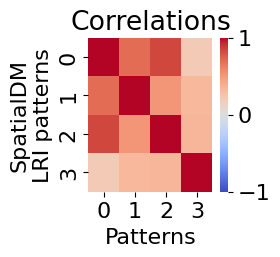

In [44]:
# column wise correlation bettwen two numpy arrays X and Y
plt.figure(figsize=(2, 2))
plt.rcParams.update({'font.size': 16})
sns.heatmap(np.corrcoef(patterns.T), vmin=-1, vmax=1, cmap='coolwarm')
plt.xlabel('Patterns')
plt.title('Correlations')
plt.ylabel('SpatialDM\nLRI patterns')


# plt.tight_layout(bbox_inches='tight')
# change title position
# plt.title('Correlations')
plt.show()


In [46]:
adata = anndata.read_h5ad('../example_datasets/PDAC/PDAC_A/adata.h5ad')
sc.pp.filter_genes(adata, min_cells=20)

In [47]:
sq.gr.spatial_neighbors(adata, key_added='spatial')
sq.gr.spatial_autocorr(
    adata,
    genes=adata.var_names,
    mode="moran",
    n_perms=1000,
    n_jobs=10,
)

100%|██████████| 1000/1000 [00:30<00:00, 32.33/s]


In [48]:
# op.util.adata_moranI(adata, out_f=out_f)
plt.rcParams['font.size'] = 13
ds = 'PDAC'
sample_name = 'PDAC-A'
merged_df,lri_pw_list,gene_lr_list,gene_pw_list = op.vis.svg_svi_relation(adata, idata, title='PDAC', is_human=adata.uns['is_human'], top=50)
plt.savefig(f'../figures/{ds}_{sample_name}_relation.png', dpi=600,bbox_inches='tight')

Human KEGG_2021_Human
Using human LR pair dataset.
50
0.6035150614189488 0.5020579897991562 0.3444489665525177


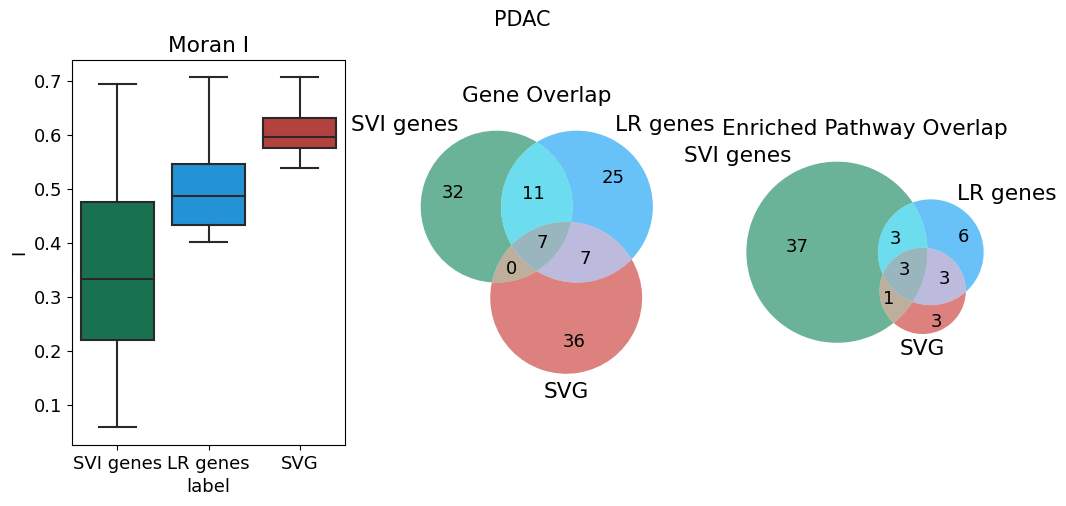

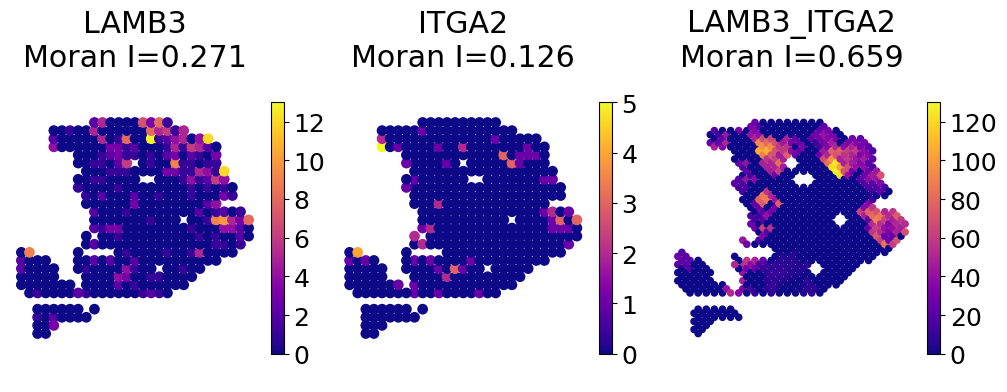

In [49]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update({'font.size': 18})
plt.figure(figsize=(12, 4))
base = 1
for i in ['LAMB3', 'ITGA2']:
    plt.subplot(1, 3, base)
    im=plt.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], c=adata.to_df()[i].to_numpy(), s=45, cmap='plasma')
    # sns.scatterplot(marker_score, x='x', y='y', hue=i, s=10, linewidth=0)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.axis('equal')
    plt.axis('off')
    plt.title(f'{i}\nMoran I={"%.3f" % adata.uns["moranI"].loc[i]["I"]}')
    base += 1
plt.subplot(1, 3, base)
i = 'LAMB3_ITGA2'
im=plt.scatter(idata.obsm['spatial'][:, 0], idata.obsm['spatial'][:, 1], c=idata.to_df()[i].to_numpy(), s=20, cmap='plasma')
# sns.scatterplot(marker_score, x='x', y='y', hue=i, s=10, linewidth=0)
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.axis('equal')
plt.axis('off')
plt.title(f'{i}\nMoran I={"%.3f" % idata.uns["moranI"].loc[i]["I"]}')
base += 1
rcParams.update(rcParamsDefault)
plt.show()

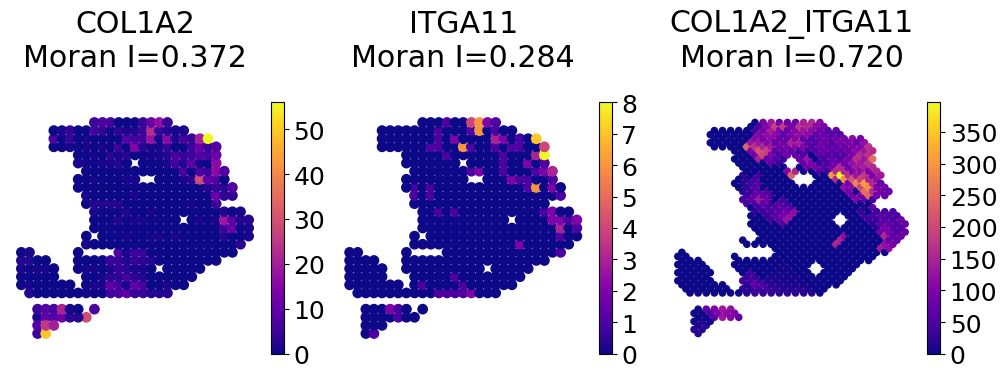

In [50]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update({'font.size': 18})
plt.figure(figsize=(12, 4))
base = 1
for i in ['COL1A2', 'ITGA11']:
    plt.subplot(1, 3, base)
    im=plt.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1], c=adata.to_df()[i].to_numpy(), s=45, cmap='plasma')
    # sns.scatterplot(marker_score, x='x', y='y', hue=i, s=10, linewidth=0)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.axis('equal')
    plt.axis('off')
    plt.title(f'{i}\nMoran I={"%.3f" % adata.uns["moranI"].loc[i]["I"]}')
    base += 1
plt.subplot(1, 3, base)
i = 'COL1A2_ITGA11'
im=plt.scatter(idata.obsm['spatial'][:, 0], idata.obsm['spatial'][:, 1], c=idata.to_df()[i].to_numpy(), s=20, cmap='plasma')
# sns.scatterplot(marker_score, x='x', y='y', hue=i, s=10, linewidth=0)
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.axis('equal')
plt.axis('off')
plt.title(f'{i}\nMoran I={"%.3f" % idata.uns["moranI"].loc[i]["I"]}')
base += 1
rcParams.update(rcParamsDefault)
plt.show()

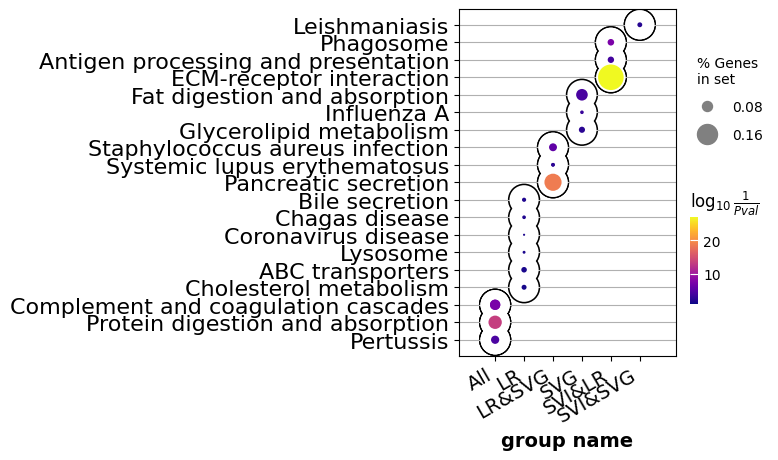

In [51]:
import gseapy
membership=pd.get_dummies(merged_df.set_index('Term')['group']).groupby('Term').sum().astype(str).agg('-'.join, axis=1)
merged_df['group name'] = membership.loc[merged_df.Term].to_numpy()
rename_dict = {
    '1-0-0': 'LR', '1-0-1':'SVI&LR', '0-0-1':'SVI', '1-1-1':'All', '0-1-0':'SVG', '0-1-1':'SVI&SVG', '1-1-0':'LR&SVG'
}
merged_df['group name'] = merged_df['group name'] .astype('category').cat.rename_categories(rename_dict).to_numpy()
merged_df_sub = merged_df[merged_df["group name"]!="SVI"]
op.vis.enrichment(merged_df_sub,x_key='group name', cutoff=0.05, top_term=20,size=15,figsize=(3.5,4.5))
# op.vis.enrichment(merged_df,x_key='group name', cutoff=0.05, top_term=20,size=15,save=f'../figures/{ds}_{sample_name}_relation_enrichment.png')

pattern

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_non-member vs. 1_member: Mann-Whitney-Wilcoxon test smaller with Benjamini-Hochberg correction, P_val:7.260e-10 U_stat=3.210e+02
0_non-member vs. 0_member: Mann-Whitney-Wilcoxon test smaller with Benjamini-Hochberg correction, P_val:8.091e-09 U_stat=1.140e+02
2_non-member vs. 2_member: Mann-Whitney-Wilcoxon test smaller with Benjamini-Hochberg correction, P_val:7.912e-08 U_stat=2.500e+01
3_non-member vs. 3_member: Mann-Whitney-Wilcoxon test smaller with Benjamini-Hochberg correction, P_val:1.346e-44 U_stat=9.506e+03


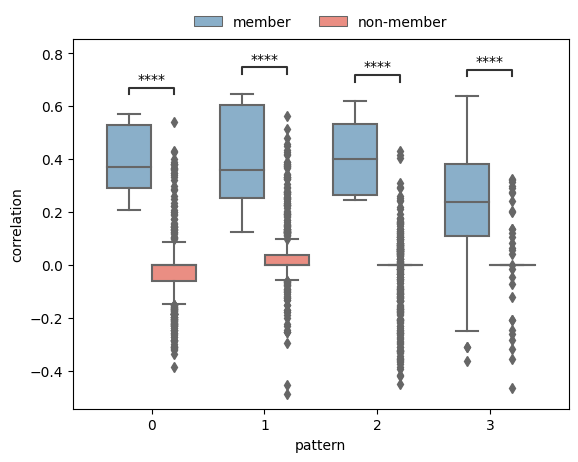

In [57]:
plt.rcParams.update({'font.size': 10})

op.svi.eva_pattern(idata)
plt.show()

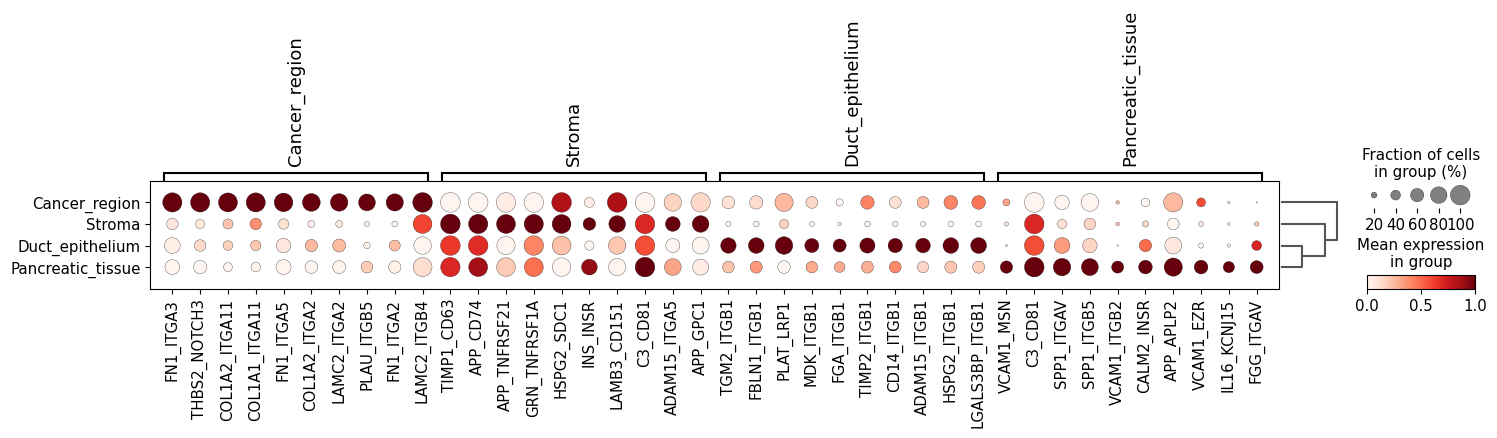

In [58]:
with plt.rc_context():
    plt.rcParams.update({'font.size': 13})
    sc.pl.rank_genes_groups_dotplot(adata_lri, standard_scale='var', show=False)
    plt.show()

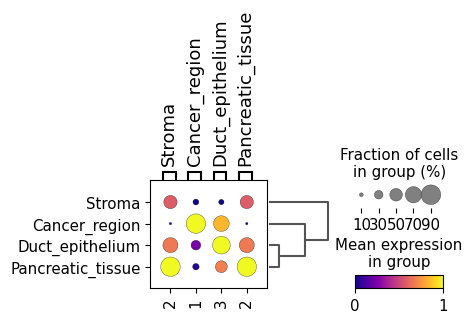

In [59]:
with plt.rc_context(): 
    plt.rcParams.update({'font.size': 13})
    sc.pl.rank_genes_groups_dotplot(adata_pattern, standard_scale='var', n_genes=1, show=False, cmap='plasma')
    plt.show()
    
